In [170]:
# coding=utf-8
import numpy as np
import struct
import os

import matplotlib.pyplot as plt

# from data_process import load_mnist, load_data
# from train import train
# from evaluate import predict, cal_accuracy

# Load Data

In [171]:
# Load the MNIST data for this exercise
# mat_data contain the training and testing images or labels.
#   Each matrix has size [m,n] for images where:
#      m is the number of examples.
#      n is the number of pixels in each image.
#   or Each matrix has size [m,1] for labels contain the corresponding labels (0 to 9) where:
#      m is the number of examples.
def load_mnist(file_dir, is_images='True'):
    # Read binary data
    bin_file = open(file_dir, 'rb')
    bin_data = bin_file.read()
    bin_file.close()
    # Analysis file header
    if is_images:
        # Read images
        fmt_header = '>iiii'
        magic, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, 0)
    else:
        # Read labels
        fmt_header = '>ii'
        magic, num_images = struct.unpack_from(fmt_header, bin_data, 0)
        num_rows, num_cols = 1, 1
    data_size = num_images * num_rows * num_cols
    mat_data = struct.unpack_from('>' + str(data_size) + 'B', bin_data, struct.calcsize(fmt_header)) # 将数据解释为无符号字节序列 表示数据由data_size个字节组成，采用大端字节序
    mat_data = np.reshape(mat_data, [num_images, num_rows * num_cols])
    print('Load images from %s, number: %d, data shape: %s' % (file_dir, num_images, str(mat_data.shape)))
    return mat_data



# call the load_mnist function to get the images and labels of training set and testing set
def load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir):
    print('Loading MNIST data from files...')
    train_images = load_mnist(os.path.join(mnist_dir, train_data_dir), True)
    train_labels = load_mnist(os.path.join(mnist_dir, train_label_dir), False)
    test_images = load_mnist(os.path.join(mnist_dir, test_data_dir), True)
    test_labels = load_mnist(os.path.join(mnist_dir, test_label_dir), False)
    return train_images, train_labels, test_images, test_labels

In [172]:
mnist_dir = "mnist_data/"
train_data_dir = "train-images.idx3-ubyte"
train_label_dir = "train-labels.idx1-ubyte"
test_data_dir = "t10k-images.idx3-ubyte"
test_label_dir = "t10k-labels.idx1-ubyte"
k = 10
iters = 500
alpha = 0.5

# get the data
train_images, train_labels, test_images, test_labels = load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir)
print("Got data. ")



Loading MNIST data from files...
Load images from mnist_data/train-images.idx3-ubyte, number: 60000, data shape: (60000, 784)
Load images from mnist_data/train-labels.idx1-ubyte, number: 60000, data shape: (60000, 1)
Load images from mnist_data/t10k-images.idx3-ubyte, number: 10000, data shape: (10000, 784)
Load images from mnist_data/t10k-labels.idx1-ubyte, number: 10000, data shape: (10000, 1)
Got data. 


# Train

In [173]:
# tranfer the image from gray to binary and get the one-hot style labels
def data_convert(x, y, m, k):
    # 将灰度图像二值化，像素值小于等于40的设为0，大于40的设为1
    x[x <= 40] = 0
    x[x > 40] = 1
    ont_hot_y = np.zeros((m,k)) # 创建一个大小为(m,k)的全零矩阵，用于存储独热编码的标签
    # 为每个样本生成独热编码标签
    for t in np.arange(0, m):
        ont_hot_y[t, y[t]] = 1
    ont_hot_y = ont_hot_y.T # 将独热编码矩阵进行转置，使得每一列代表一个样本的标签
    return x, ont_hot_y

def train(train_images, train_labels, k, iters = 5, alpha = 0.5):
    m, n = train_images.shape
    # data processing
    x, y = data_convert(train_images, train_labels, m, k) # x:[m,n], y:[1,m]  TODO 为何不是y:[k,m]?
    # print(y.shape)  (10, 60000)
    
    
    # Initialize theta.  Use a matrix where each column corresponds to a class,
    # and each row is a classifier coefficient for that class.
    theta = np.random.rand(k, n) # [k,n]
    # print(theta.shape)  (10, 784)
    
    # do the softmax regression
    theta = softmax_regression(theta, x, y, iters, alpha)
    return theta

# x:train y:lable
def softmax_regression(theta, x, y, iters, alpha):
    # TODO: Do the softmax regression by computing the gradient and
    # the objective function value of every iteration and update the theta
    
    # print("theta.shape",theta.shape) (10, 784)       theta[10, 784]
    # print("y.shape",y.shape) (10, 60000)             y[10, 60000]
    # print("x.shape",x.shape) (60000, 784)            x[60000, 784]
    m = x.shape[0]
    # print(m) m = 60000                               m = 60000
    loss_history = []
    for i in range(iters):
    # for i in tqdm(range(iters), desc="Training"):
        scores = np.dot(theta, x.T)  # Calculate scores for each class
        # print(scores.shape) (10, 60000)
        exp_scores = np.exp(scores - np.max(scores, axis = 0))  # Subtract max score for numerical stability
        # print(exp_scores.shape) (10, 60000)
        probabilities = exp_scores / np.sum(exp_scores, axis = 0)  # Calculate class probabilities
        # print("probabilities",probabilities.shape) (10, 60000)
        
        # probabilities = np.exp(np.matmul(theta, x.T)) / np.sum(np.exp(np.matmul(theta, x.T)), axis=0)
        f = -np.sum(y * np.log(probabilities)) / m
        loss_history.append(f)
        # Calculate the gradient
        g = np.dot((probabilities - y), x) / m
        # Update theta using gradient descent
        theta -= alpha * g
        
        if (i + 1) % 10 == 0:
            print(f"Iteration {i + 1}/{iters}, f: {f}")


    plt.plot(range(1, iters + 1), loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss vs. Iterations')
    plt.show()

    return theta



# Predict

In [174]:
def predict(test_images, theta):
    scores = np.dot(test_images, theta.T)
    preds = np.argmax(scores, axis=1)
    return preds


def cal_accuracy(y_pred, y):
    # TODO: Compute the accuracy among the test set and store it in acc
    # check lenth
    if len(y_pred) != len(y):
        raise ValueError("The lengths of the predicted values and the actual labels are not consistent")

    correct = 0
    total = len(y)

    for i in range(total):
        if y_pred[i] == y[i]:
            correct += 1

    accuracy = (correct / total) * 100.0

    return accuracy

iters = 1000

alpha = 0.7

Iteration 10/1000, Loss: 1.2386420173104469
Iteration 20/1000, Loss: 0.8416572757234604
Iteration 30/1000, Loss: 0.6481350824837653
Iteration 40/1000, Loss: 0.5863225085425171
Iteration 50/1000, Loss: 0.5501313837440669
Iteration 60/1000, Loss: 0.5237002812292375
Iteration 70/1000, Loss: 0.5031926300148702
Iteration 80/1000, Loss: 0.48664484423205484
Iteration 90/1000, Loss: 0.47290110503703975
Iteration 100/1000, Loss: 0.46123054682168896
Iteration 110/1000, Loss: 0.4511453243915732
Iteration 120/1000, Loss: 0.4423056529912237
Iteration 130/1000, Loss: 0.43446659591304476
Iteration 140/1000, Loss: 0.4274464967460577
Iteration 150/1000, Loss: 0.42110735863364
Iteration 160/1000, Loss: 0.41534216984413647
Iteration 170/1000, Loss: 0.41006644783549123
Iteration 180/1000, Loss: 0.4052124407489661
Iteration 190/1000, Loss: 0.40072505566083105
Iteration 200/1000, Loss: 0.39655893900969735
Iteration 210/1000, Loss: 0.39267634369339927
Iteration 220/1000, Loss: 0.3890455442863963
Iteration 23

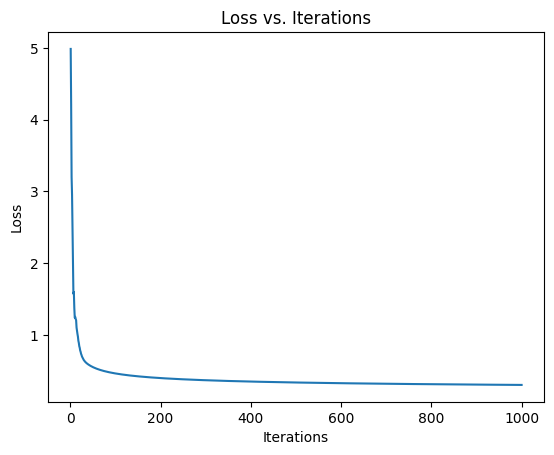

Finished training. 


In [175]:
# train the classifier
theta = train(train_images, train_labels, k, iters, alpha)
print("Finished training. ")

In [176]:
# evaluate on the testset
y_predict = predict(test_images, theta)
accuracy  = cal_accuracy(y_predict, test_labels)
print('accuracy:', accuracy, '%')
print("Finished test. ")

accuracy: 91.49000000000001 %
Finished test. 


iters = 500

alpha = 0.7

Iteration 10/500, Loss: 1.316458926483001
Iteration 20/500, Loss: 0.8579933513184608
Iteration 30/500, Loss: 0.6631364006855729
Iteration 40/500, Loss: 0.595498033236516
Iteration 50/500, Loss: 0.5560177528363106
Iteration 60/500, Loss: 0.5276160473907551
Iteration 70/500, Loss: 0.5058769519476395
Iteration 80/500, Loss: 0.4885412869788958
Iteration 90/500, Loss: 0.47428674395125103
Iteration 100/500, Loss: 0.46228272651539204
Iteration 110/500, Loss: 0.4519793618942596
Iteration 120/500, Loss: 0.44299731441277546
Iteration 130/500, Loss: 0.43506595728147024
Iteration 140/500, Loss: 0.4279866913223309
Iteration 150/500, Loss: 0.4216102024552878
Iteration 160/500, Loss: 0.41582184387366633
Iteration 170/500, Loss: 0.410531948659208
Iteration 180/500, Loss: 0.40566923644150754
Iteration 190/500, Loss: 0.4011762187400293
Iteration 200/500, Loss: 0.3970059289094313
Iteration 210/500, Loss: 0.3931195503366493
Iteration 220/500, Loss: 0.38948466652222224
Iteration 230/500, Loss: 0.3860739498

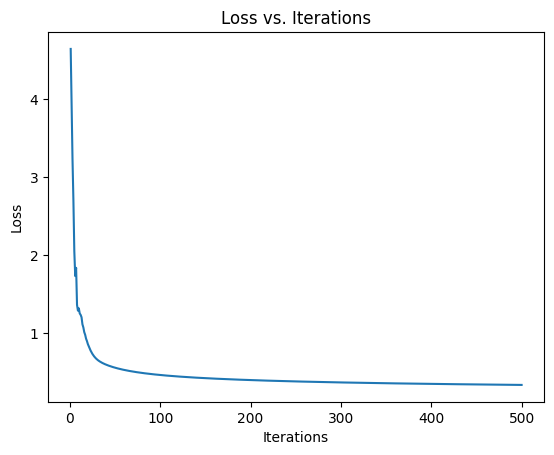

Finished training. 


In [167]:
# train the classifier
theta = train(train_images, train_labels, k, iters, alpha)
print("Finished training. ")

In [169]:
# evaluate on the testset
y_predict = predict(test_images, theta)
accuracy  = cal_accuracy(y_predict, test_labels)
print('accuracy:', accuracy, '%')
print("Finished test. ")

accuracy: 90.94 %
Finished test. 


iters = 500

alpha = 0.5

Iteration 10/500, Loss: 1.3621191936662609
Iteration 20/500, Loss: 0.9066392334815665
Iteration 30/500, Loss: 0.7532328623190359
Iteration 40/500, Loss: 0.671188814325303
Iteration 50/500, Loss: 0.6187940243665443
Iteration 60/500, Loss: 0.5818413761823182
Iteration 70/500, Loss: 0.5540581562844167
Iteration 80/500, Loss: 0.5322169743706778
Iteration 90/500, Loss: 0.514473678282375
Iteration 100/500, Loss: 0.49969072305968554
Iteration 110/500, Loss: 0.4871245438228658
Iteration 120/500, Loss: 0.47626663852110657
Iteration 130/500, Loss: 0.46675646980929086
Iteration 140/500, Loss: 0.45833074434376936
Iteration 150/500, Loss: 0.4507923800661781
Iteration 160/500, Loss: 0.4439907295129865
Iteration 170/500, Loss: 0.43780853845316386
Iteration 180/500, Loss: 0.43215309202601165
Iteration 190/500, Loss: 0.4269500507834378
Iteration 200/500, Loss: 0.4221390642626535
Iteration 210/500, Loss: 0.4176705887292374
Iteration 220/500, Loss: 0.4135035387989891
Iteration 230/500, Loss: 0.4096035279

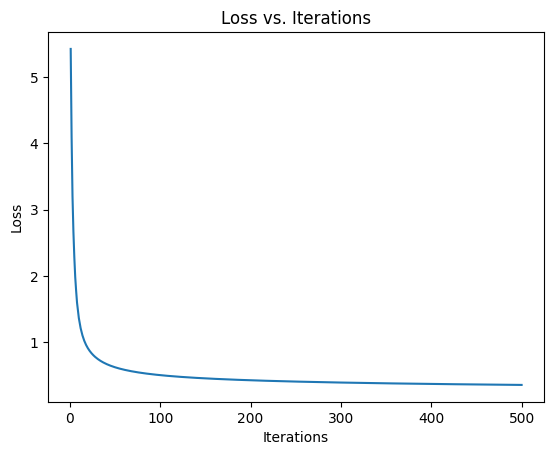

Finished training. 


In [160]:
# train the classifier
theta = train(train_images, train_labels, k, iters, alpha)
print("Finished training. ")

In [161]:
# evaluate on the testset
y_predict = predict(test_images, theta)
accuracy  = cal_accuracy(y_predict, test_labels)
print('accuracy:', accuracy, '%')
print("Finished test. ")

accuracy: 90.71000000000001 %
Finished test. 


iters = 1000

alpha = 0.5

Iteration 10/500, Loss: 1.3130018757482267
Iteration 20/500, Loss: 0.8670808501136291
Iteration 30/500, Loss: 0.7240060404114047
Iteration 40/500, Loss: 0.6504926675153055
Iteration 50/500, Loss: 0.6034394285606711
Iteration 60/500, Loss: 0.5700216893454827
Iteration 70/500, Loss: 0.5446928075635258
Iteration 80/500, Loss: 0.5246246684110247
Iteration 90/500, Loss: 0.508205050483467
Iteration 100/500, Loss: 0.4944381906792614
Iteration 110/500, Loss: 0.4826711157459473
Iteration 120/500, Loss: 0.4724553651232671
Iteration 130/500, Loss: 0.4634714013168601
Iteration 140/500, Loss: 0.45548462462336753
Iteration 150/500, Loss: 0.4483184512855226
Iteration 160/500, Loss: 0.4418371349345927
Iteration 170/500, Loss: 0.4359344161768653
Iteration 180/500, Loss: 0.4305257976497705
Iteration 190/500, Loss: 0.4255431510187956
Iteration 200/500, Loss: 0.42093086778151784
Iteration 210/500, Loss: 0.4166430580837974
Iteration 220/500, Loss: 0.4126414768265232
Iteration 230/500, Loss: 0.4088939644365

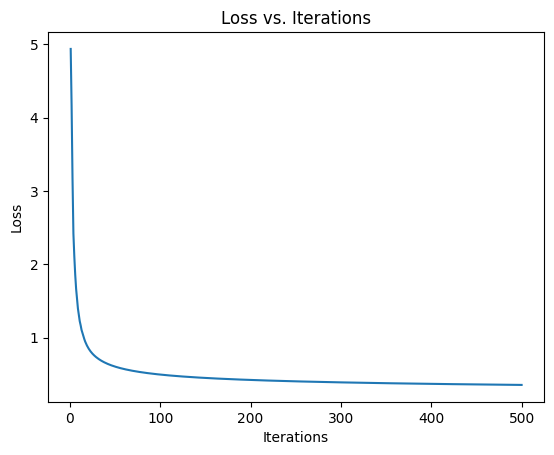

Finished training. 


In [147]:
# train the classifier
theta = train(train_images, train_labels, k, iters, alpha)
print("Finished training. ")

In [149]:
# evaluate on the testset
y_predict = predict(test_images, theta)
accuracy  = cal_accuracy(y_predict, test_labels)
print('accuracy:', accuracy, '%')
print("Finished test. ")

accuracy: 90.59 %
Finished test. 
